In [73]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.linalg import expm
from scipy import signal, linalg
import matplotlib.pyplot as plt
import control

In [74]:
def gen_ss(thetaVec):
    m = thetaVec[0]
    k = thetaVec[1]
    c = thetaVec[2]

    ndof = 1

    Ac = np.array([[0, 1],
                   [-k/m, -c/m]])

    Bc = np.array([[0],
                   [1 / m]])

    #it works, because C matrix will come from the last 'few' (1 in case od 1 dof) rows of Ac
    #Similarly D from Bc
    getidx = np.arange(ndof, 2 * ndof)
    C = Ac[getidx, :]

    D = Bc[getidx, :]

    return Ac, Bc, C, D


In [75]:


ndof = 1
dt = 0.01  # sampling period
fs = 1 / dt
T = 10  # final time
t = np.arange(0, T + dt, dt)  # time samples

# force gen.
np.random.seed(19)
utmp = 10 * np.random.randn(len(t))
b, a = butter(5, 5 / (fs / 2), 'low')
u = filtfilt(b, a, utmp)
u = u.reshape(1001,1)
true_m = 10
true_k = 100
kappa = np.log(true_k)
true_c = 0.4
#zeta = true_c / (2 * true_m * np.sqrt(true_k / true_m))
true_theta = np.array([true_m, np.exp(kappa), true_c])
Ac, Bc, C, D = gen_ss(true_theta)

# Convert continuous to discrete
Cfull = np.vstack((np.eye(2 * ndof), C))
Dfull = np.array([[0], [0], [1 / true_m]])
sysc = signal.StateSpace(Ac, Bc, Cfull, Dfull)
sysd = sysc.to_discrete(dt)
Ad = sysd.A
Bd = sysd.B

#Ad_analytical = expm(Ac*dt) (Checks out)
#Bd_analyt = np.linalg.solve(Ac, (Ad - np.eye(2 * ndof)) @ Bc)



In [76]:
#True state:
z0 = np.array([0, 0])
tout, output, _ = signal.lsim2(sysc, u, t, X0=z0)


Text(0, 0.5, 'displacement (m)')

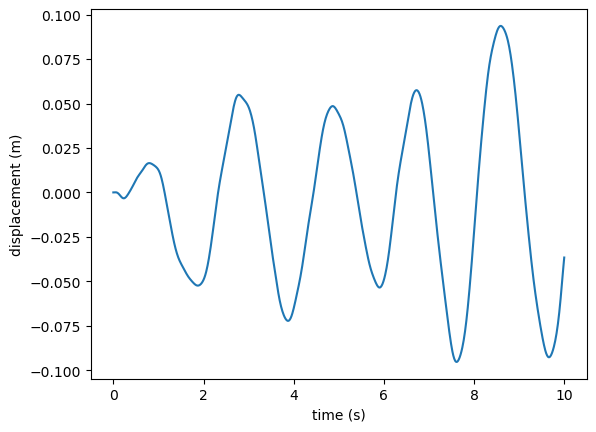

In [77]:
disp = output[:, 0]
plt.plot(t, disp)
plt.xlabel("time (s)")
plt.ylabel("displacement (m)")

Text(0, 0.5, 'velocity (m/s)')

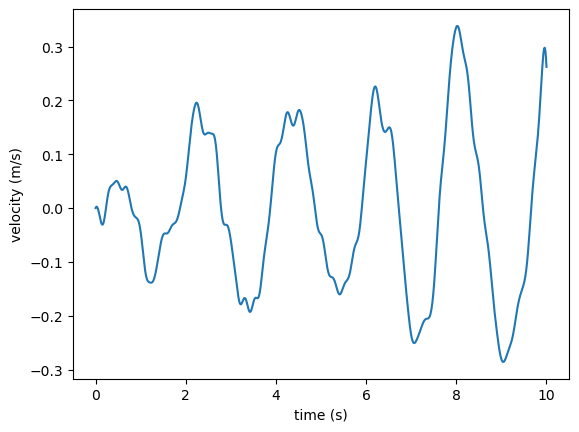

In [78]:
vel = output[:, 1]
plt.plot(t, vel)
plt.xlabel("time (s)")
plt.ylabel("velocity (m/s)")

Text(0, 0.5, 'acc (m/s^2)')

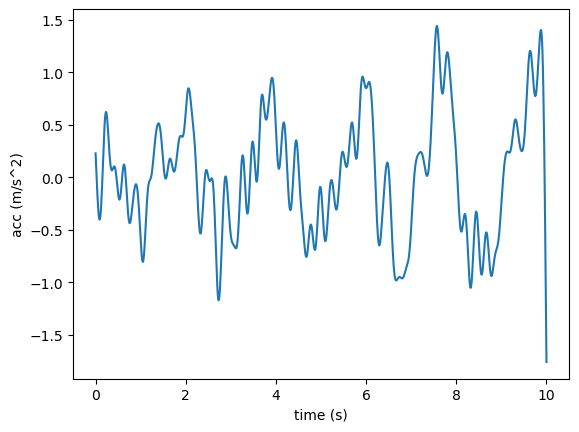

In [79]:
acc = output[:, 2]
plt.plot(t, acc)
plt.xlabel("time (s)")
plt.ylabel("acc (m/s^2)")

In [80]:
#Add Noise
noise_percentage = 10;
noise_std = noise_percentage/100*(np.sqrt(np.mean(acc**2)));
noise = noise_std*np.random.randn(np.size(acc));
y = acc + noise;
y = y.reshape(1001,1)

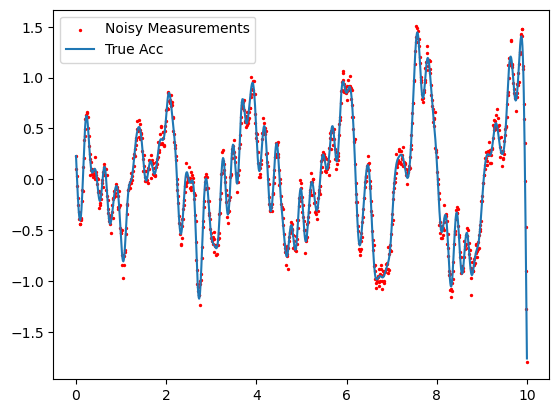

In [81]:
plt.scatter(t,y, label='Noisy Measurements', c='r', s = 2)
plt.plot(t, acc, label = 'True Acc')
plt.legend()

In [82]:
Q = np.diag([0.001, 0.01])
R = 10

Kalman Filter:

In [83]:
#H is C
def kalman_filter(m_0, P_0, A,B,H, D, Q, R,u, observations):
    M = m_0.shape[-1]
    steps, N = observations.shape
    
    kf_m = np.empty((steps, M))
    kf_P = np.empty((steps, M, M))
    
    m = m_0
    P = P_0
    u = u.reshape(1001,1)
    for i in range(steps):
        y = observations[i]
        m = A @ m + B @ u[i]
        P = A @ P @ A.T + Q
        
        S = H @ P @ H.T + R
        # More efficient and stable way of computing K = P @ H.T @ linalg.inv(S)
        # This also leverages the fact that S is known to be a positive definite matrix (assume_a="pos")
        K = linalg.solve(S.T, H @ P, assume_a="pos").T 
        
        m = m + K @ (y - (H @ m + D @ u[i]))
        P = P - K @ S @ K.T
        
        kf_m[i] = m
        kf_P[i] = P
    return kf_m, kf_P

Note: dont do log(det). Instead use eigen values. 
Since, \
det(A) = prod(eig(A)) \
=> log(det(A)) = sum(log(eig(A)))

In [84]:
def get_discrete_mat(m,k,c):
    true_theta = np.array([m, k, c], dtype=object)
    Ac, Bc, C, D = gen_ss(true_theta)
    Cfull = np.vstack((np.eye(2 * ndof), C))
    Dfull = np.array([[0], [0], [1 / true_m]])
    sysc = signal.StateSpace(Ac, Bc, Cfull, Dfull)
    sysd = sysc.to_discrete(dt)
    Ad = sysd.A
    Bd = sysd.B
    
    return Ad, Bd, C, D

In [85]:
m_0 = z0
P_0 = np.diag([0.1, 0.1])

In [86]:
kf_m, kf_P = kalman_filter(m_0, P_0, Ad,Bd, C, D, Q, R,u, y)

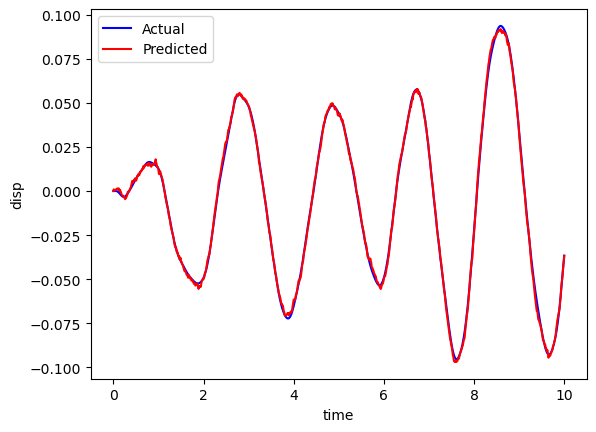

In [87]:
plt.plot(t, disp, c= 'blue', label = 'Actual')
plt.plot(t, kf_m[:,0], c= 'red', label = 'Predicted')
plt.xlabel("time")
plt.ylabel("disp")
plt.legend()

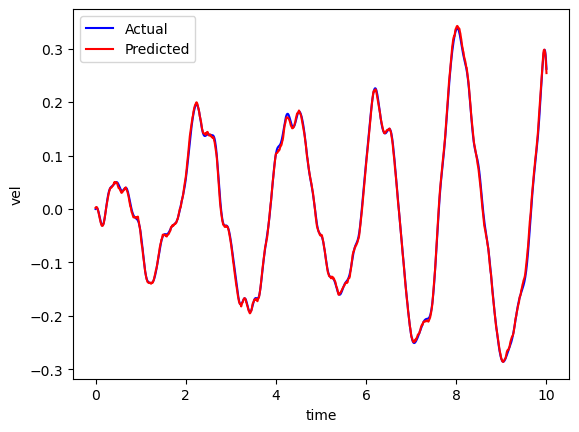

In [88]:
plt.plot(t, vel, c= 'blue', label = 'Actual')
plt.plot(t, kf_m[:,1], c= 'red', label = 'Predicted')
plt.xlabel("time")
plt.ylabel("vel")
plt.legend()

In [89]:
acc_pred = (C @ kf_m.T + D @ u.T).T
acc_pred.shape

(1001, 1)

In [90]:
y.shape

(1001, 1)

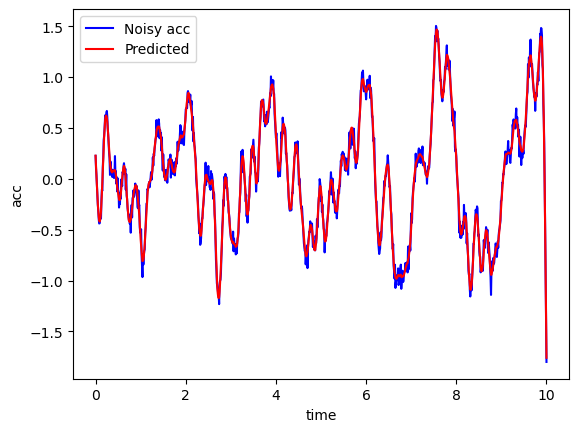

In [91]:
plt.plot(t, y, c= 'blue', label = 'Noisy acc')
plt.plot(t, acc_pred, c= 'red', label = 'Predicted')
plt.xlabel('time')
plt.ylabel('acc')
plt.legend()

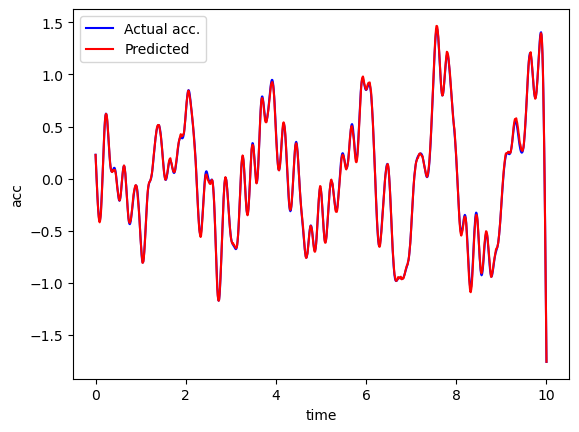

In [92]:
plt.plot(t, acc, c= 'blue', label = 'Actual acc.')
plt.plot(t, acc_pred, c= 'red', label = 'Predicted')
plt.xlabel('time')
plt.ylabel('acc')
plt.legend()

Say that our initial state estimation was a bit off:

In [93]:
m_0 = np.array([0.4, 0.1]) #intsead of [0,0]
P_0 = np.diag([0.1, 0.1])

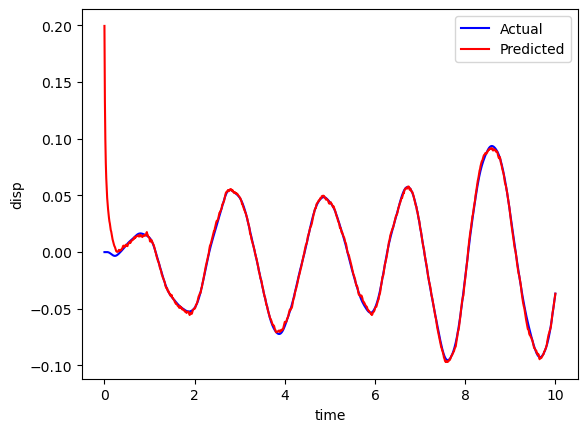

In [94]:
kf_m, kf_P = kalman_filter(m_0, P_0, Ad,Bd, C, D, Q, R,u, y)
plt.plot(t, disp, c= 'blue', label = 'Actual')
plt.plot(t, kf_m[:,0], c= 'red', label = 'Predicted')
plt.xlabel("time")
plt.ylabel("disp")
plt.legend()


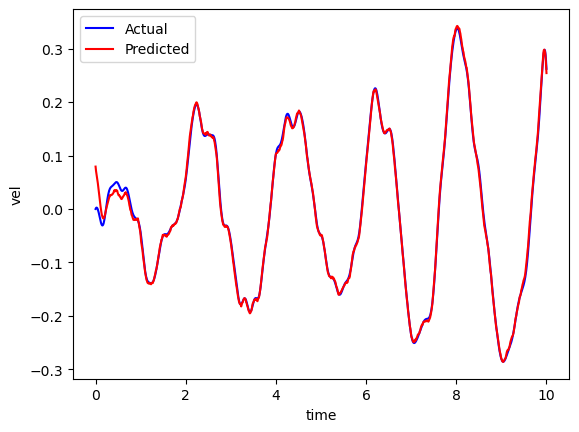

In [95]:
plt.plot(t, vel, c= 'blue', label = 'Actual')
plt.plot(t, kf_m[:,1], c= 'red', label = 'Predicted')
plt.xlabel("time")
plt.ylabel("vel")
plt.legend()

In [96]:
acc_pred = (C @ kf_m.T + D @ u.T).T

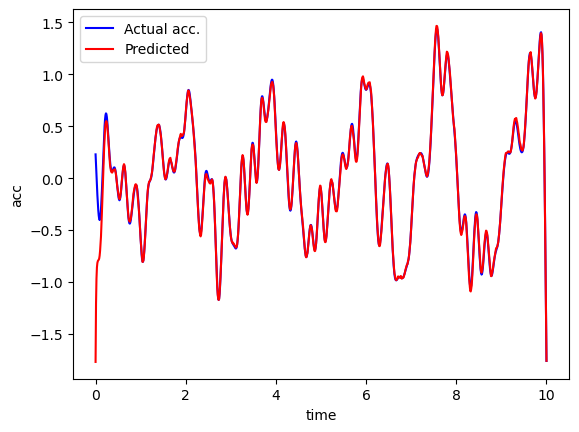

In [97]:
plt.plot(t, acc, c= 'blue', label = 'Actual acc.')
plt.plot(t, acc_pred, c= 'red', label = 'Predicted')
plt.xlabel('time')
plt.ylabel('acc')
plt.legend()

We still get pretty good results